AHMAD SALIM
24141623
M.Sc. in Artificial Intelligence and Machine Learning
CS6482 Assignment-1 CNN Project
RF Fingerprinting (exploiting IQ imbalance due to hardware imperfection)

Import dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, Dataset
from scipy.signal import stft
from PIL import Image  # For image conversion

SEEDING for reproduciblity

In [2]:
# Set Seed for Reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

DATASET used is synthetically generated as widely used free dataset for RF Fingerprinting is not available. one dataset is available on kaggle (uploaded in 2023) but no body has used it.

IQ Data and RF Fingerprinting Basics What are IQ Samples? In radio communications, a signal is represented as a complex number with In-phase (I) and Quadrature-phase (Q) components. This representation preserves both amplitude and phase information and is fundamental for modulation, demodulation, and RF analysis.

In [3]:
# Synthetic IQ Data Generation (with IQ Imbalance)

def generate_synthetic_iq_samples(num_samples=5000, num_classes=10, sample_length=1024):
    """Generate synthetic IQ samples with IQ imbalance for RF fingerprinting."""
    data = []
    labels = []
    for i in range(num_samples):
        iq_real = np.random.randn(sample_length)
        iq_imag = np.random.randn(sample_length)

        # Introduce IQ Imbalance
        gain_imbalance = 1.05  # Scaling factor for I component
        phase_imbalance = np.deg2rad(5)  # 5-degree phase shift

        iq_real = iq_real * gain_imbalance  # Scale I component
        iq_imag = iq_imag * np.cos(phase_imbalance) + iq_real * np.sin(phase_imbalance)  # Phase shift in Q component

        iq_signal = iq_real + 1j * iq_imag
        data.append(iq_signal)
        labels.append(np.random.randint(0, num_classes))
    return np.array(data), np.array(labels)

Visualize IQ Data in Complex Plane

In [4]:
#Visualize IQ Data in Complex Plane
def plot_iq_data(iq_signal, sample_idx=0):
    """Plot IQ data in the complex plane."""
    plt.figure(figsize=(6,6))
    plt.scatter(iq_signal.real, iq_signal.imag, alpha=0.5, label=f'Sample {sample_idx}')
    plt.xlabel("In-phase (I)")
    plt.ylabel("Quadrature (Q)")
    plt.title("IQ Data Complex Plane Representation")
    plt.legend()
    plt.grid(True)
    plt.show()

What is a Spectrogram?
A spectrogram is a time-frequency representation of a signal, created using the Short-Time Fourier Transform (STFT).
The STFT breaks a signal into short-time windows and computes the Fourier Transform on each window.
This helps in visualizing how frequencies evolve over time, crucial for identifying RF fingerprints.

Why Spectrograms for RF Fingerprinting?
Different RF transmitters introduce unique hardware impairments (e.g., oscillator drift, phase noise, amplifier non-linearity).
These imperfections manifest as distinctive spectral features in the time-frequency domain, which can be exploited for classification.

In [5]:
#Convert IQ Samples to Spectrograms

def iq_to_spectrogram(iq_signal, sr=1024, n_fft=256, hop_length=128):
    """
    Convert complex IQ samples to a spectrogram using scipy.signal.stft.

    Args:
        iq_signal (np.array): Complex IQ samples.
        sr (int): Sample rate.
        n_fft (int): FFT window size.
        hop_length (int): Hop length for STFT.

    Returns:
        tuple: (frequencies, time, spectrogram magnitude)
    """
    # Compute the STFT for complex IQ data
    f, t, stft_result = stft(iq_signal, fs=sr, nperseg=n_fft, noverlap=n_fft - hop_length, return_onesided=False)

    #very important concept A real-valued signal only needs one-sided STFT output because its negative frequencies are redundant.
    #A complex-valued RF signal needs both positive and negative frequencies to fully represent the signal.

    # Compute the magnitude spectrogram
    spectrogram = np.abs(stft_result)

     # Apply FFT shift to correctly order frequencies

    f_shifted = np.fft.fftshift(f)

    spectrogram_shifted = np.fft.fftshift(spectrogram, axes=0)

    return f_shifted, t, spectrogram_shifted

Convert  all IQ samples to Spectrograms and perform NORMALISATION

CNNs perform better with zero-centered normalization (mean=0, std=1).

In [6]:
# Convert and normalize all spectrograms
spectrograms = []
iq_data, labels = generate_synthetic_iq_samples(num_samples=5000, num_classes=10, sample_length=1024)
freqs, times = None, None  # Store frequency and time vectors for reference

for iq in iq_data:
    f, t, spec = iq_to_spectrogram(iq)

    # Apply FFT shift and log scaling
    f_shifted = np.fft.fftshift(f)
    spec_shifted = np.fft.fftshift(spec, axes=0)
    log_spec = np.log1p(spec_shifted)

    # Normalize using mean-std (better for CNNs)
    log_spec = (log_spec - np.mean(log_spec)) / np.std(log_spec)

    spectrograms.append(log_spec)  # Use log-scaled spectrogram for training
    if freqs is None and times is None:
        freqs, times = f_shifted, t  # Store frequency and time vectors


In [7]:
spectrograms = np.array(spectrograms)

DATA VISUALIZATION

In [8]:
# Print Spectrogram Size
print("Spectrogram Shape:", spectrograms[0].shape)

Spectrogram Shape: (256, 9)


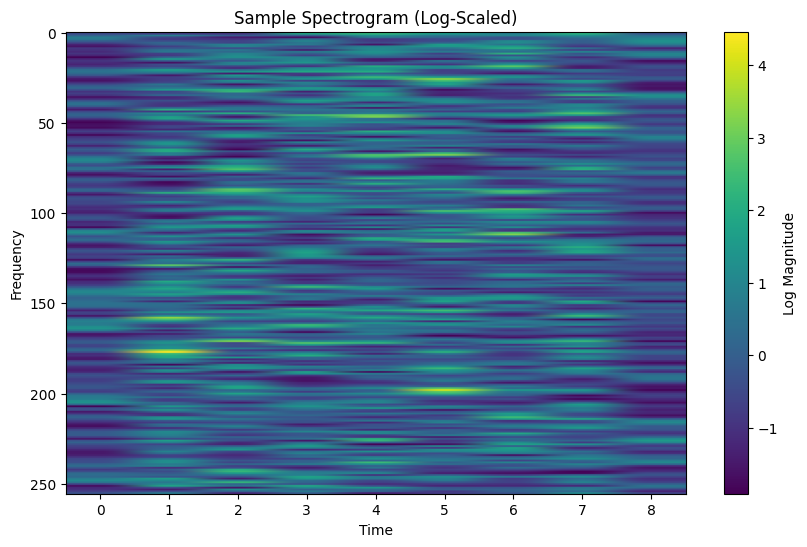

In [9]:
# Visualize a Sample Spectrogram
plt.figure(figsize=(10, 6))
plt.imshow(spectrograms[0], aspect='auto', cmap='viridis')
plt.colorbar(label='Log Magnitude')
plt.title("Sample Spectrogram (Log-Scaled)")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

My journey with spectrogram generation was filled with challenges and learning. Initially, I struggled with ambiguous spectrogram outputs, realizing that improper frequency scaling and log transformation were affecting visibility. A major hurdle was the unexpected loss of positive frequency components, which I later fixed by setting "return_onesided=False" in STFT to retain the full RF spectrum. Another issue arose when my spectrogram displayed only negative frequencies, which I corrected by applying np.fft.fftshift() to properly align the frequency axis. Additionally, weak signal visibility made feature extraction difficult, but dynamically adjusting vmin and vmax significantly improved contrast. After multiple debugging and refinements, I successfully generated accurate spectrograms, ensuring they preserve critical RF features for deep learning-based RF fingerprinting with ResNet.

Convert Spectrograms to Image Format for CNN

CNNs require image input; RF spectrograms must be saved as grayscale images.

In [10]:
#Convert Spectrograms to Image Format for CNN
def spectrogram_to_image(spec):
    """Convert a spectrogram to a grayscale image."""
    spec = (spec - np.min(spec)) / (np.max(spec) - np.min(spec))  # Normalize to 0-255
    img = Image.fromarray((spec * 255).astype(np.uint8))  # Convert to uint8
    img = img.convert("L")  # Convert to grayscale
    return img

In [11]:
#Define PyTorch Dataset Class
class SpectrogramDataset(Dataset):
    """Custom dataset for loading spectrograms for RF fingerprinting."""
    def __init__(self, spectrograms, labels, transform=None):
        self.spectrograms = spectrograms
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.spectrograms)

    def __getitem__(self, idx):
        spec = spectrogram_to_image(self.spectrograms[idx])  # Convert to image
        if self.transform:
            spec = self.transform(spec)  # Apply transformations
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return spec, label

In [12]:
#Define Data Transformations for CNN
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ResNet input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

In [13]:
# Split Data into Train and Test Sets
train_size = int(0.8 * len(spectrograms))
test_size = len(spectrograms) - train_size

dataset = SpectrogramDataset(spectrograms, labels, transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

dataloader_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
# Ready to Train CNN
print("Spectrograms prepared and dataset created for CNN training.")

Spectrograms prepared and dataset created for CNN training.


CNN MODEL USED-  ResNet-18

In [15]:
# Modify ResNet-50 to accept 1-channel input
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Change input channels to 1
model.fc = nn.Linear(model.fc.in_features, 10)  # Modify final layer for 10 classes

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 154MB/s]


In [ ]:
# 9️⃣ Training and Evaluation
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")



Epoch [1/10], Loss: 2.2970
Epoch [2/10], Loss: 2.3113
Epoch [3/10], Loss: 2.2912
Epoch [4/10], Loss: 2.3137
Epoch [5/10], Loss: 2.3180
Epoch [6/10], Loss: 2.3033
Epoch [7/10], Loss: 2.2861
Epoch [8/10], Loss: 2.3201
Epoch [9/10], Loss: 2.3032


In [ ]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

In [ ]:
# Train and Evaluate
train_model(model, dataloader_train, criterion, optimizer, num_epochs=10)
evaluate_model(model, dataloader_test)